In [10]:
import pandas as pd
import numpy.ma as ma

import diff_classifier.aws as aws
import diff_classifier.pca as pca
import diff_classifier.msd as msd

import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib
import scipy.stats as stats

In [2]:
features = []
#featofvar = 'Type and Serum'

folder = 'Cell_Studies/10_16_18_cell_study' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 5
types = ['PS', 'PEG']
slices = [1, 2]
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1']
to_track = []

counter = 0
for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            to_track.append('{}_{}_XY{}'.format(typ, slic, num))
            print('{}_{}_XY{}'.format(typ, slic, num))

PS_1_XY1
PS_1_XY2
PS_1_XY3
PS_1_XY4
PS_1_XY5
PS_2_XY1
PS_2_XY2
PS_2_XY3
PS_2_XY4
PS_2_XY5
PEG_1_XY1
PEG_1_XY2
PEG_1_XY3
PEG_1_XY4
PEG_1_XY5
PEG_2_XY1
PEG_2_XY2
PEG_2_XY3
PEG_2_XY4
PEG_2_XY5


In [14]:
geomean_in = {}
gSEM_in = {}
geomean_out = {}
gSEM_out = {}
geomean = {}
gSEM = {}
for sample_name in to_track:
    # Users can toggle between using pre-calculated geomean files and calculating new values by commenting out the relevant
    # lines of code within the for loop.
    aws.download_s3('{}/geomean_out_{}.csv'.format(folder, sample_name), 'geomean_out_{}.csv'.format(sample_name), bucket_name=bucket)
    aws.download_s3('{}/geoSEM_out_{}.csv'.format(folder, sample_name), 'geoSEM_out_{}.csv'.format(sample_name), bucket_name=bucket)
    geomean[sample_name] = np.genfromtxt('geomean_out_{}.csv'.format(sample_name))
    gSEM[sample_name] = np.genfromtxt('geoSEM_out_{}.csv'.format(sample_name))
    
    #aws.download_s3('{}/msd_{}.csv'.format(folder, sample_name), 'msd_{}.csv'.format(sample_name), bucket_name=bucket)
    #geomean_in[sample_name], gSEM_in[sample_name], geomean_out[sample_name], gSEM_out[sample_name] = geomean_msdisp(sample_name,
    #                                                                                                                umppx=umppx, fps=fps,
    #                                                                                                                remote_folder=folder, bucket=bucket)
    print('Done with {}'.format(sample_name))

Done with PS_1_XY1
Done with PS_1_XY2
Done with PS_1_XY3
Done with PS_1_XY4
Done with PS_1_XY5
Done with PS_2_XY1
Done with PS_2_XY2
Done with PS_2_XY3
Done with PS_2_XY4
Done with PS_2_XY5
Done with PEG_1_XY1
Done with PEG_1_XY2
Done with PEG_1_XY3
Done with PEG_1_XY4
Done with PEG_1_XY5
Done with PEG_2_XY1
Done with PEG_2_XY2
Done with PEG_2_XY3
Done with PEG_2_XY4
Done with PEG_2_XY5


In [ ]:
def geomean_msdisp(prefix, umppx=0.16, fps=100.02, upload=True,
                   remote_folder="01_18_Experiment", bucket='ccurtis.data',
                   backup_frames=651):

    merged = pd.read_csv('msd_{}.csv'.format(prefix))
    try:
        particles = int(max(merged['Track_ID']))
        frames = int(max(merged['Frame']))
        
        cell_status = np.zeros(particles+1)
        for i in range(0, particles+1):
            cell_status[i] = np.nanmean(merged.loc[merged.Track_ID == i, 'Cell Status'].values) > 0.95
        
        ypos_in = np.zeros((particles+1, frames+1))
        ypos_out = np.zeros((particles+1, frames+1))

        for i in range(0, particles+1):
            if cell_status[i]:
                ypos_in[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
                #xpos_in = merged.loc[merged.Track_ID == i, 'Frame']/fps
                ypos_out[i, :] = np.zeros(frames+1)
            else:
                ypos_out[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
                #xpos_in = merged.loc[merged.Track_ID == i, 'Frame']/fps
                ypos_in[i, :] = np.zeros(frames+1)


        geo_mean_out = np.nanmean(ma.log(ypos_out), axis=0)
        geo_stder_out = ma.masked_equal(stats.sem(ma.log(ypos_out), axis=0,
                                              nan_policy='omit'), 0.0)
        geo_mean_in = np.nanmean(ma.log(ypos_in), axis=0)
        geo_stder_in = ma.masked_equal(stats.sem(ma.log(ypos_in), axis=0,
                                              nan_policy='omit'), 0.0)

    except ValueError:
        geo_mean_in = np.nan*np.ones(backup_frames)
        geo_stder_in = np.nan*np.ones(backup_frames)
        
        geo_mean_out = np.nan*np.ones(backup_frames)
        geo_stder_out = np.nan*np.ones(backup_frames)

    np.savetxt('geomean_in_{}.csv'.format(prefix), geo_mean_in, delimiter=",")
    np.savetxt('geoSEM_in_{}.csv'.format(prefix), geo_stder_in, delimiter=",")
    
    np.savetxt('geomean_out_{}.csv'.format(prefix), geo_mean_out, delimiter=",")
    np.savetxt('geoSEM_out_{}.csv'.format(prefix), geo_stder_out, delimiter=",")

    if upload:
        aws.upload_s3('geomean_in_{}.csv'.format(prefix),
                      remote_folder+'/'+'geomean_in_{}.csv'.format(prefix),
                      bucket_name=bucket)
        aws.upload_s3('geoSEM_in_{}.csv'.format(prefix),
                      remote_folder+'/'+'geoSEM_in_{}.csv'.format(prefix),
                      bucket_name=bucket)
    
        aws.upload_s3('geomean_out_{}.csv'.format(prefix),
                      remote_folder+'/'+'geomean_out_{}.csv'.format(prefix),
                      bucket_name=bucket)
        aws.upload_s3('geoSEM_out_{}.csv'.format(prefix),
                      remote_folder+'/'+'geoSEM_out_{}.csv'.format(prefix),
                      bucket_name=bucket)

    return geo_mean_in, geo_stder_in, geo_mean_out, geo_stder_out

In [15]:
exps = []
for typ in types:
    to_avg = []
    for sample in to_track:
        combi = '{}_'.format(typ)
        exp = '{}_out'.format(typ)
        if combi in sample:
            to_avg.append(sample)

    weights, wh1 = msd.precision_weight(to_avg, gSEM)
    geodata = msd.precision_averaging(to_avg, geomean, gSEM, weights,
                                      bucket=bucket, folder=folder, experiment=exp)
    exps.append(exp)

/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:609: RuntimeWarning: divide by zero encountered in true_divide
  w_holder[video_counter, :] = 1/(geo_stder[sample]*geo_stder[sample])
/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:656: RuntimeWarning: divide by zero encountered in true_divide
  w_holder[video_counter, :] = (1/(geo_stder[sample]*geo_stder[sample])
/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:660: RuntimeWarning: divide by zero encountered in true_divide
  gstder_holder[video_counter, :] = 1/(geo_stder[sample]*geo_stder[sample]


In [34]:
exps = ['PEG_out', 'PS_out', 'PEG_in', 'PS_in']

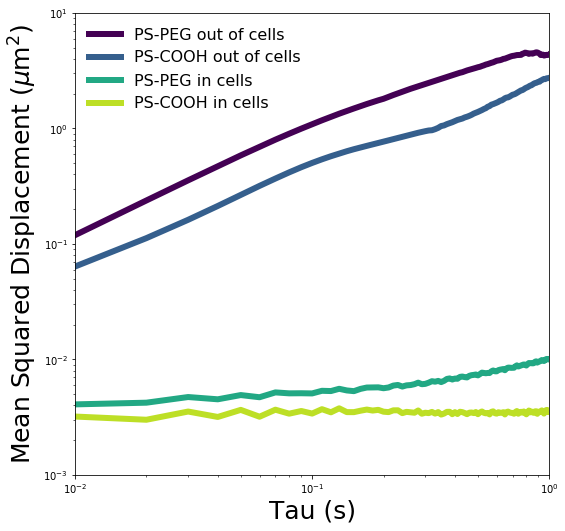

In [35]:
labels = ['PS-PEG out of cells', 'PS-COOH out of cells', 'PS-PEG in cells', 'PS-COOH in cells']
msd.plot_all_experiments(exps,
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder, labels=labels)

In [25]:
counter = 0
status = ['in', 'out']
to_track = []
for stat in status:
    for typ in types:
        for slic in slices:
            for num in range(1, vids+1):
                to_track.append('{}_{}_{}_XY{}'.format(stat, typ, slic, num))
                #print('{}_{}_{}_XY{}'.format(stat, typ, slic, num))

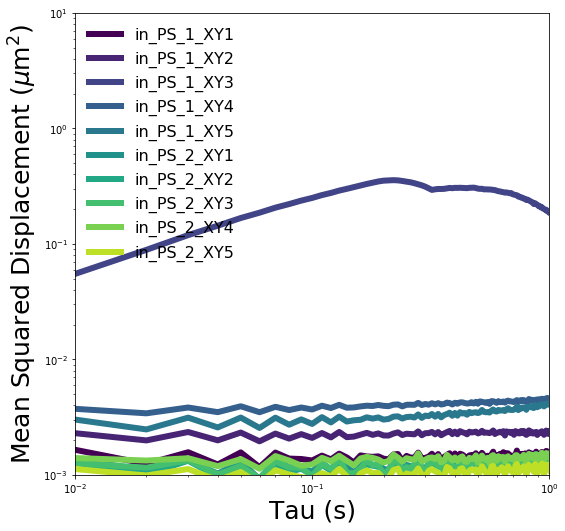

In [27]:
msd.plot_all_experiments(to_track[0:10],
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

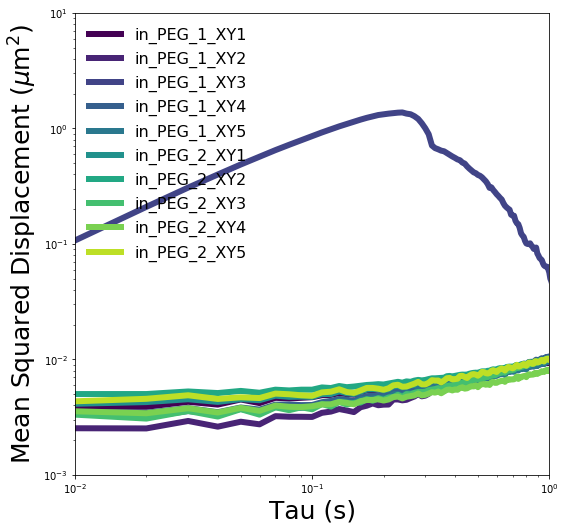

In [28]:
msd.plot_all_experiments(to_track[10:20],
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

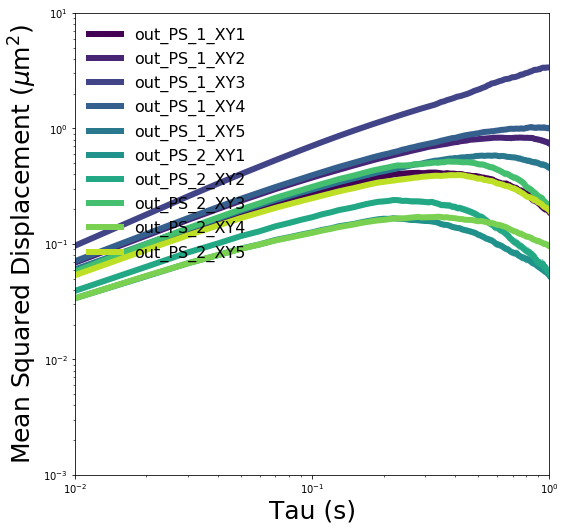

In [29]:
msd.plot_all_experiments(to_track[20:30],
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

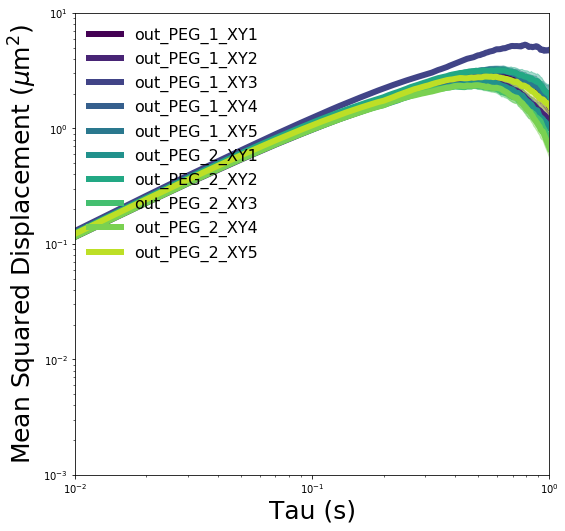

In [30]:
msd.plot_all_experiments(to_track[30:40],
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

In [ ]:
merged = msds[1]
particles = int(max(merged['Track_ID']))
frames = int(max(merged['Frame']))
ypos = np.zeros((particles+1, frames+1))

In [ ]:
umppx=0.07
fps=100.02
upload=True
backup_frames=651

In [ ]:
cell_status = np.zeros(particles+1)
for i in range(0, particles+1):
    cell_status[i] = np.nanmean(merged.loc[merged.Track_ID == i, 'Cell Status'].values) > 0.95

In [ ]:
cell_status.mean()

In [ ]:
ypos_in = np.zeros((particles+1, frames+1))
ypos_out = np.zeros((particles+1, frames+1))
for i in range(0, particles+1):
    if cell_status[i]:
        ypos_in[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
        #xpos_in = merged.loc[merged.Track_ID == i, 'Frame']/fps
        ypos_out[i, :] = np.zeros(frames+1)
    else:
        ypos_out[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
        #xpos_in = merged.loc[merged.Track_ID == i, 'Frame']/fps
        ypos_in[i, :] = np.zeros(frames+1)
        

geo_mean_out = np.nanmean(ma.log(ypos_out), axis=0)
geo_stder_out = ma.masked_equal(stats.sem(ma.log(ypos_out), axis=0,
                                      nan_policy='omit'), 0.0)
geo_mean_in = np.nanmean(ma.log(ypos_in), axis=0)
geo_stder_in = ma.masked_equal(stats.sem(ma.log(ypos_in), axis=0,
                                      nan_policy='omit'), 0.0)